In [75]:
import numpy as np
import os
import pandas as pd
import time
import umap
import numba
from pathlib import Path
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpImage
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score, precision_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics, \
class_accuracy_metrics, mean_scores_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
#import multiprocessing as mp
import my_utils
import my_architectures
import my_dataloaders
# import my_gwpy_and_fractals
import my_transformations
IMG_SIZE = (224,224)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
# calculating the amount of workers usable
number_of_workers = 4

label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
#classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
classes = ['Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['Whistle', 'Tomte', 'Scattered_Light']


In [77]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
#image_dir = 'C:\\Users\\Brian.Baert\\FD_CL\\images\\images'
train_dir = 'D:\\Users\\Brian\\FD_CL\\images\\images'
#test_dir = 'C:\\Users\Brian.Baert\\FD_CL\\images\\test'
test_dir = 'D:\\Users\Brian\\FD_CL\\images\\test'
#FD_location = 'C:\\Users\Brian.Baert\\FD_CL\\reduced_ids_50.npy'
FD_location = 'D:\\Users\Brian\\FD_CL\\reduced_ids_50.npy'

#Load in fratal data
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

#Three classes
classes = ['Whistle', 'Tomte', 'Scattered_Light']

#First image ID = 896

#Label the instances
train_labels = []
train_labels.extend(['Whistle'] * 876)
train_labels.extend(['Tomte'] * 876)
train_labels.extend(['Scattered_Light'] * 876)
test_labels = []
test_labels.extend(['Whistle'] * 20)
test_labels.extend(['Tomte'] * 20)
test_labels.extend(['Scattered_Light'] * 20)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [81]:
fractal_matrices.shape

(2688, 50, 56)

In [82]:
fractal_matrices[0]

array([[0.57451844, 0.574585  , 0.61747295, ..., 0.8614793 , 0.8710429 ,
        0.86270547],
       [0.82187957, 0.8134645 , 0.8314725 , ..., 0.87468857, 0.8983555 ,
        0.89641106],
       [0.48615664, 0.5589393 , 0.5859381 , ..., 0.81507933, 0.76803046,
        0.7939468 ],
       ...,
       [0.58207494, 0.478571  , 0.5393343 , ..., 0.7123621 , 0.6273871 ,
        0.64899284],
       [0.45105952, 0.30550978, 0.43062353, ..., 0.39758435, 0.5520664 ,
        0.39632282],
       [0.40403458, 0.32956344, 0.49127063, ..., 0.8159749 , 0.73265237,
        0.83331215]], dtype=float32)

In [83]:
import re
def find_index(filename):
    match = re.search(r'\d+', filename)
    if match:
        n_index = match.group(0)
        return(int(n_index)-896)

In [84]:
test = 'img_896.png'
print(find_index(test))

0


In [85]:
test_indices = []
for class_name in classes:
    classpath = os.path.join(test_dir, class_name)
    for file in os.listdir(classpath):
        test_indices.append(find_index(file))

In [86]:
len(test_indices)

60

In [87]:
test_fractal_matrices = np.zeros((60,50,56))
j = 0
for i in test_indices:
    test_fractal_matrices[j] = fractal_matrices[i]
    j = j + 1

In [88]:
test_fractal_matrices.shape

(60, 50, 56)

In [89]:
temp = np.delete(fractal_matrices, test_indices, axis=0)
train_fractal_matrices = temp

In [90]:
train_fractal_matrices.shape

(2628, 50, 56)

In [91]:
import torch
from sklearn.preprocessing import LabelEncoder
train_fractal_matrices = torch.from_numpy(train_fractal_matrices).float()  
test_fractal_matrices = torch.from_numpy(test_fractal_matrices).float()
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(train_labels)
le.fit(test_labels)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(train_labels)
Y_test_encoded = le.transform(test_labels)
# Convert the encoded labels to a long tensor
train_labels = torch.from_numpy(Y_train_encoded).long()
test_labels = torch.from_numpy(Y_test_encoded).long()

In [92]:
train_labels

tensor([2, 2, 2,  ..., 0, 0, 0])

D:\Users\Brian\FD_CL\images\images\Whistle
img_1000.png
tensor(2)


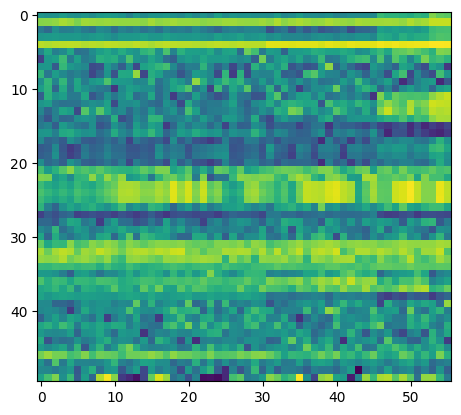

<class 'str'>


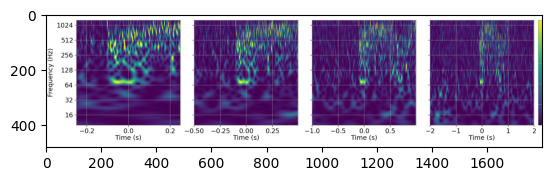

In [17]:
for class_name in classes:
    classpath = os.path.join(train_dir, class_name)
    print(classpath)
    for file in os.listdir(classpath):
        print(f"{file}")
        indx = find_index(file)
        print(train_labels[indx])
        plt.imshow(fractal_matrices[indx])
        plt.show()
        print(type(file))
        plt.imshow(mpImage.imread(os.path.join(classpath,file)))
        plt.show()
        break
    break

In [93]:
train_dataset = my_dataloaders.FractalImages(root=train_dir, cls=classes, transform=my_transformations.transformFD_Image)
test_dataset = my_dataloaders.FractalImages(root=test_dir, cls=classes, transform=my_transformations.transformFD_Image)

In [94]:
(train_fractal_matrices).shape

torch.Size([2628, 50, 56])

In [95]:
train_labels.shape

torch.Size([2628])

In [96]:
torch.as_tensor(train_labels)

tensor([2, 2, 2,  ..., 0, 0, 0])

In [97]:
train_fd_dataset = my_dataloaders.FractalDataset(train_fractal_matrices , train_labels)
test_fd_dataset = my_dataloaders.FractalDataset(test_fractal_matrices , test_labels)
train_fd_dataset_av = AvalancheDataset(train_fd_dataset)
test_fd_dataset_av = AvalancheDataset(test_fd_dataset)

In [98]:
train_fd_dataset_av.targets = [label.tolist() for i, label in enumerate(train_fd_dataset.labels)]
test_fd_dataset_av.targets = [label.tolist() for i, label in enumerate(test_fd_dataset.labels)]
train_fd_dataset_av.uniques = list(set(train_fd_dataset.labels))
test_fd_dataset_av.uniques = list(set(test_fd_dataset.labels))

In [99]:
train_fd_loader_av = torch.utils.data.DataLoader(train_fd_dataset, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_fd_loader_av = torch.utils.data.DataLoader(test_fd_dataset, batch_size=1, shuffle=False)

In [100]:
batch = next(iter(train_fd_dataset))
matrix, label = batch
print(matrix.shape)
print(label)

torch.Size([50, 56])
tensor(2)


In [101]:
train_set_av = AvalancheDataset(train_dataset)
train_loader_av = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=number_of_workers)
train_set_av.targets = [label for i, label in enumerate(train_dataset.labels)]
train_set_av.uniques = list(set(train_dataset.labels))
test_set_av = AvalancheDataset(test_dataset)
test_loader_av = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
test_set_av.targets = [label for i, label in enumerate(test_dataset.labels)]
test_set_av.uniques = list(set(test_dataset.labels))

In [102]:
model = my_architectures.MultiViewColorNet_resnet18(num_classes=3)
model.to(device)

# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()

bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=test_set_av,
    n_experiences=3,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

# log to text file
text_logger = TextLogger(open("Logs/RQ3_log.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()
class_to_indx = my_utils.classes_to_indices(classes)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [28]:
# STRATEGY
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=1.0, beta=0, mem_size=500,
    train_mb_size=64, train_epochs=10, eval_mb_size=16, device=device, evaluator=eval_plugin,
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x0000025D72676770>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.12s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2772
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9645
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.96s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0120
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:27<00:00,  1.95s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0030
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|████████████████████████████████████████████████████████████████████

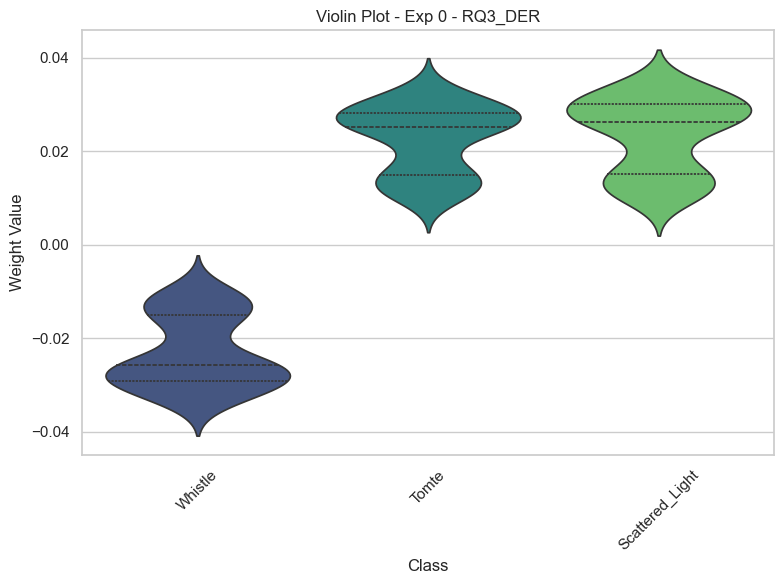

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:32<00:00,  6.61s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 5.2596
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7482
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:32<00:00,  6.61s/it]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4896
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9406
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:31<00:00,  6.57s/it]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.2609
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9553
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:31<00:00,  6.54s/it]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task0

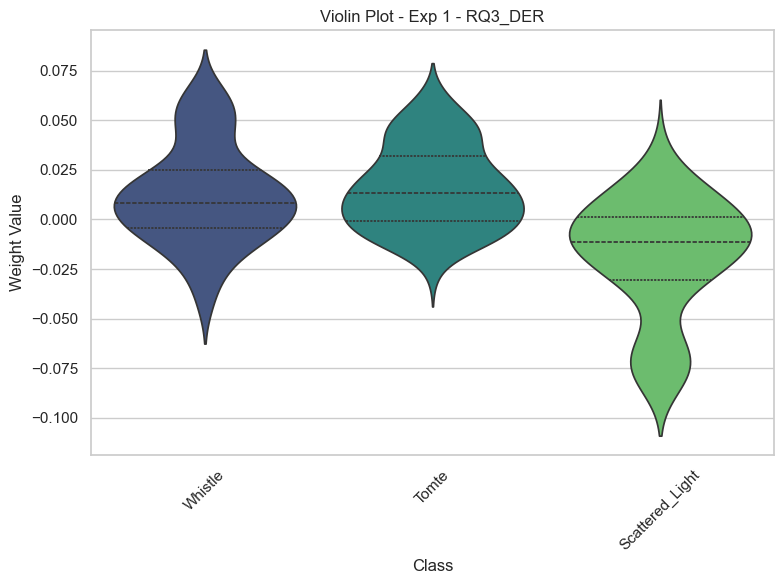

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 1.7041
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp001 = 4030.2500
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100%|████████

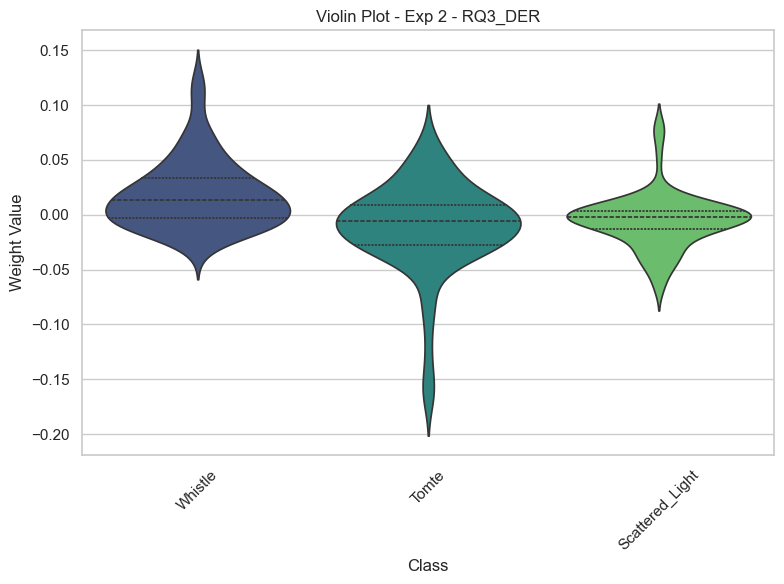

Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.6943
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp000 = 0
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4500
-- Starting eval on experience 1 (Task 0) from test stream --
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.50it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	ExperienceBWT/eval_phase/test_stream/Task000/Exp001 = -0.0000
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0002
	MaxRAMUsage_Experience/eval_phase/test_stream/Task000/Exp001 = 4045.0977
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0000
-- Starting 

In [29]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'RQ3_DER', scr=False)

In [30]:
# SAVE MODEL
my_utils.checkpoint(model, 'Models/thesis_RQ3_ImageModel.pth')

Saved Pytorch model state to  Models/thesis_RQ3_ImageModel.pth


In [103]:
# LOAD MODEL
temp = torch.load('Models/thesis_RQ3_ImageModel.pth', map_location=torch.device(device))
model.load_state_dict(temp)

<All keys matched successfully>

In [32]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 1862.6034259796143 ms
                 precision    recall  f1-score   support

        Whistle       1.00      0.45      0.62        20
          Tomte       0.67      1.00      0.80        20
Scattered_Light       0.95      1.00      0.98        20

       accuracy                           0.82        60
      macro avg       0.87      0.82      0.80        60
   weighted avg       0.87      0.82      0.80        60



D:\Users\Brian\MscThesis_env\lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


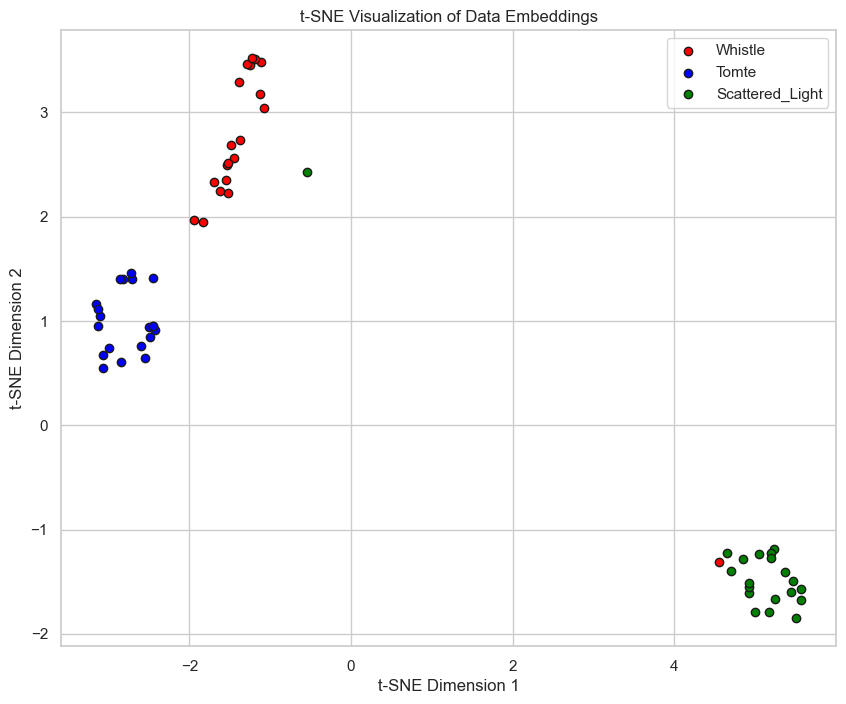

plot_tSNE_data_embedding: 4345.290184020996 ms


In [33]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_RQ3_ImageModel_test.png")

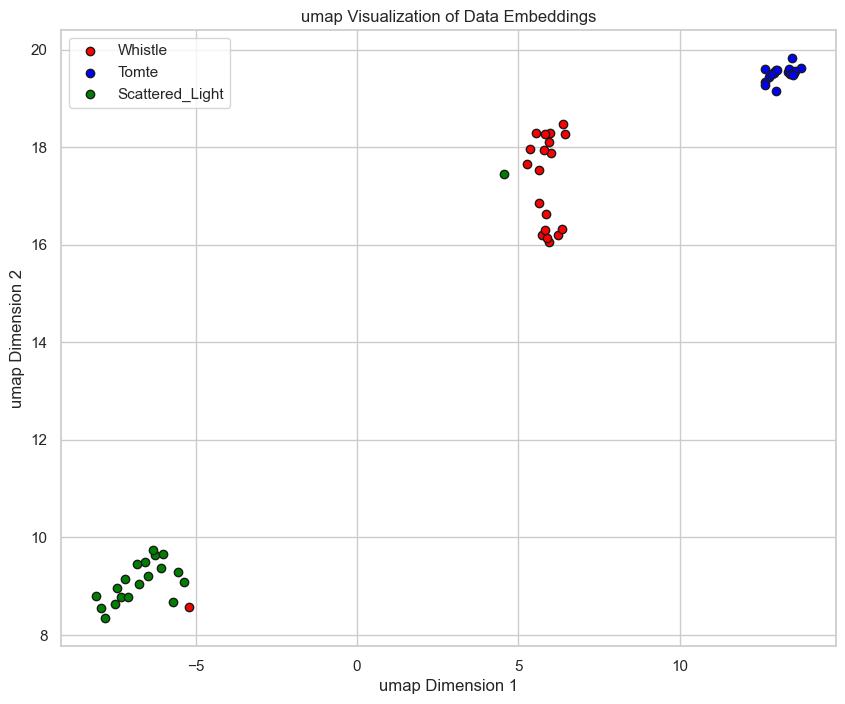

plot_umap_data_embedding: 23576.696157455444 ms


In [34]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_RQ3_ImageModel_test.png")

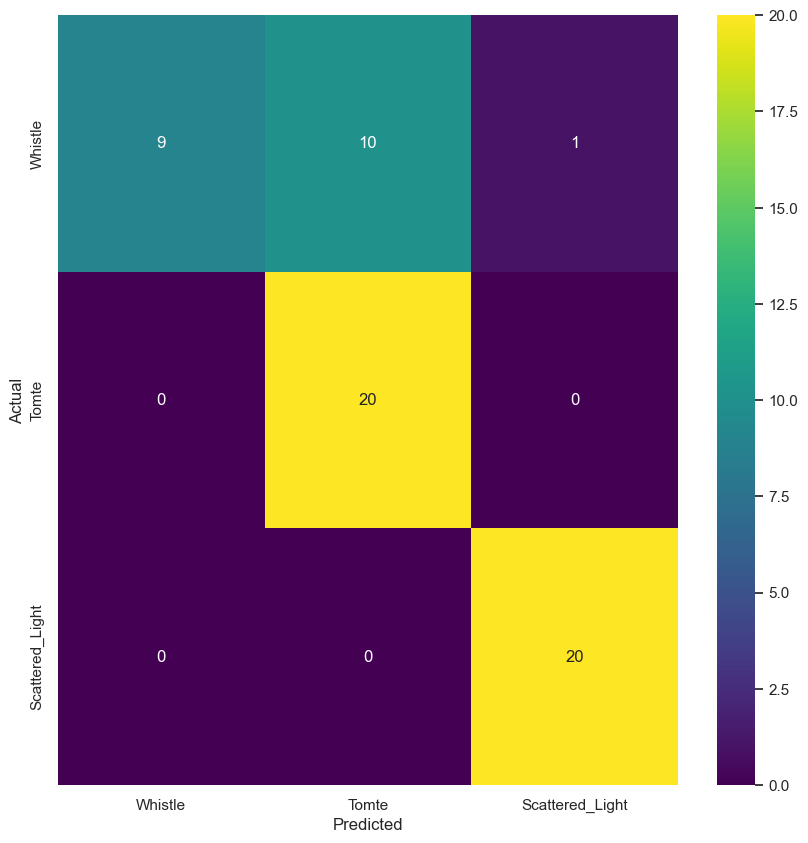

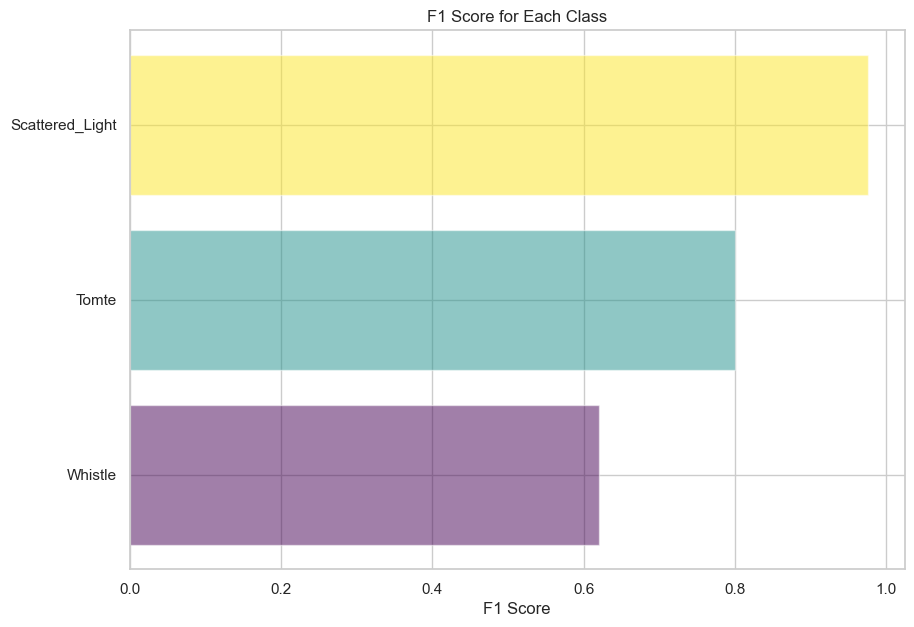

In [35]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_RQ3_ImageModel.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_RQ3_ImageModel.png')

## FD model


In [104]:
# Create an instance of the CNN architecture
model2 = my_architectures.FractalDimensionConvNet()
model2.apply(my_utils.weights_init)

bm = nc_benchmark(
    train_dataset=train_fd_dataset_av,
    test_dataset=test_fd_dataset_av,
    n_experiences=3,
    shuffle=True,
    seed=1234,
    task_labels=False
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    mean_scores_metrics(on_train=True, on_eval=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=1, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_fd_dataset)), EarlyStoppingPlugin(patience=2, val_stream_name='Loss_Epoch')]
)

In [58]:
# TRAINING
results2=[]
results2 = my_utils.cl_simple_train_loop(bm, cl_strategy, model2, optimizer, number_of_workers, classes, 'naive_fd')

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x0000025D75998220>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 16, 50, 56] to have 3 channels, but got 16 channels instead

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model2, 'Models/thesis_RQ3_FDModel.pth')

In [105]:
# LOAD MODEL
temp = torch.load('Models/thesis_RQ2_FDModel_DER.pth', map_location=torch.device(device))
model2.load_state_dict(temp)

<All keys matched successfully>

In [60]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_fd_dataset, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model2, test_loader)
print(classification_report(y_true_list, y_pred_list, target_names=classes))

get_predictions: 346.41242027282715 ms
                 precision    recall  f1-score   support

        Whistle       0.87      1.00      0.93        20
          Tomte       1.00      0.95      0.97        20
Scattered_Light       1.00      0.90      0.95        20

       accuracy                           0.95        60
      macro avg       0.96      0.95      0.95        60
   weighted avg       0.96      0.95      0.95        60



In [61]:
matrix, label = next(iter(test_loader))
print(matrix)
print(label)

tensor([[[0.5389, 0.5477, 0.5708,  ..., 0.8464, 0.8475, 0.8293],
         [0.8336, 0.8315, 0.8372,  ..., 0.8948, 0.8916, 0.9050],
         [0.4760, 0.4988, 0.4938,  ..., 0.7579, 0.7580, 0.7708],
         ...,
         [0.4322, 0.6683, 0.4046,  ..., 0.7088, 0.5852, 0.6090],
         [0.5804, 0.5961, 0.5294,  ..., 0.6881, 0.5573, 0.6063],
         [0.1630, 0.1954, 0.1660,  ..., 0.7315, 0.9550, 0.8789]]])
tensor([2])


In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
with torch.no_grad():
        for inputs, labels in test_loader_av:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            print(outputs)
            # Get the index of the maximum value
            _, preds = torch.max(outputs, 1)
            print(preds)

tensor([[ 5.0073, -4.5740, -4.0189]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[-0.4679,  0.9874, -2.1869]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[-0.6697,  1.2182, -2.2826]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[-1.3489,  1.9560, -2.5766]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[ 0.4387,  0.0400, -2.0488]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[ 3.1324, -2.0966, -4.3948]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[ 4.0766, -3.5640, -3.3403]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[ 2.7320, -2.4030, -2.2506]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[-1.0679,  1.5921, -2.2673]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[-1.3210,  1.9046, -2.4787]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([[ 2.1876, -1.8747, -1.8399]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[-2.5741,  3.2459, -3.3794]], device='cuda:0')
tensor([1], device='c

In [107]:
model2 = model2.to(device)
model2.eval()
with torch.no_grad():
        for inputs, labels in test_fd_loader_av:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model2(inputs)
            print(outputs)
            # Get the index of the maximum value
            _, preds = torch.max(outputs, 1)
            print(preds)    

tensor([[  5.0371, -12.5270,   9.8168]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[ 8.1496, -6.9093,  2.3897]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[  5.1627, -10.8562,   7.3339]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  4.4913, -13.0594,   9.2094]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  4.7279, -13.9474,  10.1837]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  5.0132, -13.6995,   9.3712]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[ 23.1359,  -8.9671, -11.0398]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([[ 3.8237, -9.5151,  7.3063]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  4.5167, -12.9961,   8.4502]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  4.4834, -13.6364,   8.6227]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  3.3696, -21.7060,  12.1547]], device='cuda:0')
tensor([2], device='cuda:0')
tensor([[  4.8325, -23.4190,  15.0033]], device='